In [69]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from alerce.core import Alerce
from astropy.stats import sigma_clipped_stats
from tqdm import tqdm
import time
import json
import glob
from astropy import units as u
import astropy.constants as const
from lc_plotting_functions import *

In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
### Matplotlib params
# Set global style parameters
mpl.rcParams.update({
    "xtick.direction": "in",   # x ticks go inward
    "ytick.direction": "in",   # y ticks go inward
    "xtick.top": True,         # show ticks on top
    "ytick.right": True,       # show ticks on right
    "xtick.minor.visible": True,  # show minor ticks if enabled
    "ytick.minor.visible": True,
    "xtick.major.size": 6,     # length of major ticks
    "ytick.major.size": 6,
    "xtick.minor.size": 3,     # length of minor ticks
    "ytick.minor.size": 3,
    "axes.linewidth": 1.5,
    "xtick.major.width": 1.5,   # thickness of major ticks
    "ytick.major.width": 1.5,
    "xtick.minor.width": 1.0,   # thickness of minor ticks
    "ytick.minor.width": 1.0,

})

In [72]:
alerce = Alerce()

In [132]:
wise_resdict = get_wise_lc_data('ZTF22abtspsw')
ztf_resdict = get_ztf_lc_data('ZTF22abtspsw', alerce, doLC=False, doStamps=False, add_forced=True)
ztf_resdict = convert_ZTF_mag_mJy(ztf_resdict, forced=True)

In [133]:
ztf_resdict['forced']

{'ZTF_g': {'mjd': array([58202.2649537, 58206.2158218, 58206.2566667, 58210.2369907,
         58210.2562037, 58234.1872454, 58234.2276389, 58237.2077431,
         58244.1938773, 58247.1864236, 58424.4977778, 58425.5411343,
         58426.4982523, 58427.505081 , 58427.5059954, 58428.5419907,
         58429.4998495, 58430.5046412, 58430.5055556, 58430.5499421,
         58431.5000463, 58432.4765046, 58434.5030208, 58434.5039468,
         58437.4828241, 58437.4846759, 58438.4999653, 58439.4932523,
         58440.4407639, 58440.4416782, 58441.4838426, 58442.4836111,
         58443.5217824, 58443.5226852, 58461.4782523, 58464.4648264,
         58467.4545139, 58472.4973495, 58475.5175347, 58480.4840509,
         58491.4311806, 58494.4665046, 58503.5348264, 58506.4785995,
         58509.2460532, 58512.3809491, 58526.4162153, 58534.2727199,
         58538.2736111, 58541.253044 , 58547.291169 , 58556.2689815,
         58559.1491782, 58562.2095023, 58567.1896412, 58569.1854745,
         58569.348

Subtracting WISE parity baselines
B1 baselines: even=0.0750, odd=-0.0788
B2 baselines: even=-0.0001, odd=-0.0283
Converting ZTF mag to mJy...


/Users/ana/Documents/LL_typeIIP/lc_plotting_functions.py:620: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax.errorbar(
/Users/ana/Documents/LL_typeIIP/lc_plotting_functions.py:934: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(0, max(ax.get_ylim()))


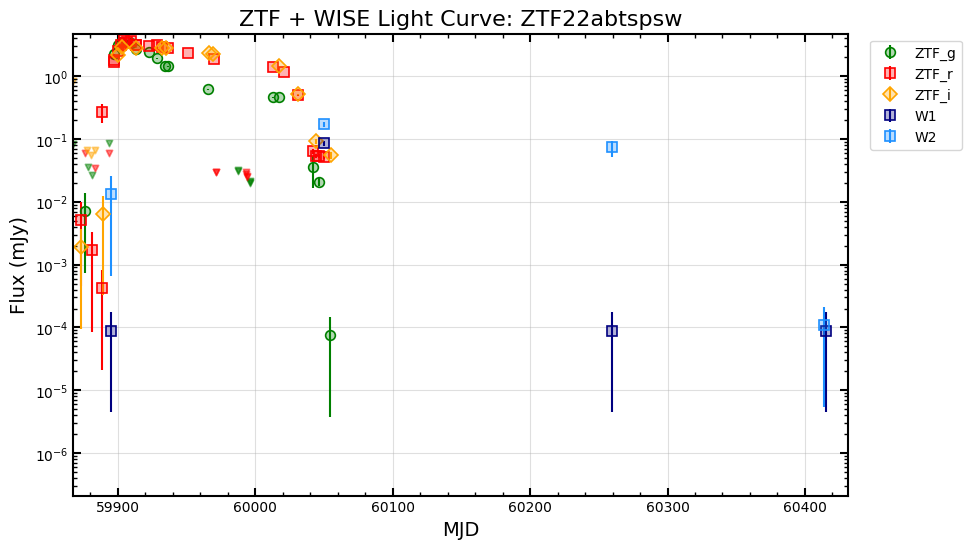

In [74]:
plot_combined_lc(ztf_resdict, wise_resdict, oid="ZTF22abtspsw", 
                 ztf_flux=True, mode="overlay", scale_wise=True, baseline_ref="wise_parity",
                 ref_band="r", logy=True)

In [134]:
# Single-epoch SEDs

# effective wavelengths [Angstrom]
lam_eff = {
    "ZTF_g": 4770.0,
    "ZTF_r": 6231.0,
    "ZTF_i": 7625.0,
    "W1": 34000.0,
    "W2": 46000.0,
}

SNR_MIN = 3.0 # minimum SNR for a detection

SED_COLORS  = {"ZTF_g":"green", "ZTF_r":"red", "ZTF_i":"orange", "W1":"navy", "W2":"dodgerblue"}
SED_MARKERS = {"ZTF_g":"o", "ZTF_r":"s", "ZTF_i":"D", "W1":"s", "W2":"s"}
SED_SIZE = 20  # dot area


# --- Helper functions for selecting nearest points and building SEDs ---
def _pick_nearest(time_mjd, val_mJy, err_mJy, mjd0, max_dt, snr_min=SNR_MIN):
    """
    Pick the nearest-in-time detection with S/N >= snr_min and positive flux.
    Parameters
    ----------
    time_mjd : array(float)
    val_mJy, err_mJy : Quantity arrays with unit mJy
    Returns (t, f, e) with f,e as Quantities or None.
    """
    if len(time_mjd) == 0:
        return None
    dt = np.abs(time_mjd - mjd0)
    order = np.argsort(dt)
    for k in order:
        if dt[k] > max_dt:
            break
        f = (val_mJy[k])
        e = (err_mJy[k])
        if np.isfinite(f) and np.isfinite(e) and e>0 and (f/e)>=snr_min and f>0:
            return (time_mjd[k], f, e)
    return None

def _nearest_ul(time_mjd, err_mJy, mjd0, max_dt, n_sigma=3):
    """
    If no detection, provide an n_sigma upper limit at the nearest time (within window).
    Returns (t_ul, F_ul) with F_ul as Quantity or None.
    """
    if len(time_mjd) == 0:
        return None
    k = np.argmin(np.abs(time_mjd - mjd0))
    if np.abs(time_mjd[k]-mjd0) <= max_dt and np.isfinite(err_mJy[k]) and err_mJy[k]>0:
        return (time_mjd[k], n_sigma*err_mJy[k])
    return None

def subtract_wise_parity_baseline_for_sed(wise_resdict, dt=50):
    """
    Copy of your parity subtraction but *no* negative clipping. Units are assumed mJy.
    wise_resdict keys: 'b1_times', 'b1_fluxes', 'b1_fluxerrs', same for b2.
    """
    if not wise_resdict:
        return {}

    w = wise_resdict.copy()

    for band in ["b1", "b2"]:
        times = np.array(w[f"{band}_times"])
        fluxes = np.array(w[f"{band}_fluxes"])

        if len(fluxes) == 0:
            continue

        peak_idx = np.nanargmax(fluxes)

        even_idx = (np.arange(len(fluxes)) % 2 == 0)
        odd_idx  = ~even_idx

        mask_even = even_idx & (times < (times[peak_idx] - dt))
        mask_odd  = odd_idx  & (times < (times[peak_idx] - dt))

        even_base = np.nanmedian(fluxes[mask_even]) if np.any(mask_even) else 0.0 
        odd_base  = np.nanmedian(fluxes[mask_odd]) if np.any(mask_odd)  else 0.0 

        corrected = fluxes.copy()
        corrected[even_idx] -= even_base
        corrected[odd_idx]  -= odd_base

        # NOTE: no flooring/clipping here
        w[f"{band}_fluxes"] = corrected
        w[f"{band}_even_baseline"] = even_base
        w[f"{band}_odd_baseline"]  = odd_base

    return w


def build_sed(mjd0, ztf_resdict, wise_resdict, max_dt_ztf=1.0, max_dt_wise=1.0, include_limits=True):
    """
    ztf_forced: dict with keys "ZTF_g/r/i" each containing arrays:
        'mjd', 'flux_mJy', 'flux_err_mJy' (numbers)
    wise_resdict: output of your WISE parser (numbers in mJy)
    """

    sed = {
        "mjd": mjd0,
        "bands": [],
        "nu": [],    # Quantity Hz
        "lam": [],   # Quantity Angstrom
        "Fnu": [],   # Quantity mJy
        "eFnu": [],  # Quantity mJy (nan for ULs)
        "is_ul": [],
        "dt_labels": [],
    }

    sed["oid"] = ztf_resdict.get("oid")
    ztf_forced = ztf_resdict['forced']

    # --- WISE, baseline removed without clipping ---
    w = subtract_wise_parity_baseline_for_sed(wise_resdict)
    wise_map = {"W1": ("b1_times","b1_fluxes","b1_fluxerrs"),
                "W2": ("b2_times","b2_fluxes","b2_fluxerrs")}

    # ZTF (forced, difference flux; assumes your dict has flux_mJy & flux_err_mJy)
    
    for band in ["ZTF_g","ZTF_r","ZTF_i"]:
        if band not in ztf_forced: 
            continue
        d = ztf_forced[band]
        tsel = _pick_nearest(
            np.asarray(d["mjd"], float),
            np.asarray(d["flux_mJy"], float),
            np.asarray(d["flux_err_mJy"], float),
            mjd0, max_dt_ztf
        )
        lam = lam_eff[band]
        nu = (const.c.value / (lam * 1e-10)) # Hz
        if tsel:
            t, f, e = tsel
            sed["bands"].append(band)
            sed["nu"].append(nu)
            sed["lam"].append(lam)
            sed["Fnu"].append(f)
            sed["eFnu"].append(e)
            sed["is_ul"].append(False)
            sed["dt_labels"].append(f"Δt={t-mjd0:+.2f} d")
        elif include_limits:
            ul = _nearest_ul(d["mjd"], d["flux_err_mJy"], mjd0, max_dt_ztf, 3)
            if ul:
                t_ul, f_ul = ul
                sed["bands"].append(band)
                sed["nu"].append(nu)
                sed["lam"].append(lam)
                sed["Fnu"].append(f_ul)
                sed["eFnu"].append(np.nan)
                sed["is_ul"].append(True)
                sed["dt_labels"].append(f"Δt={t_ul-mjd0:+.2f} d (3σ UL)")

    # WISE
    for b in ["W1","W2"]:
        tkey, fkey, ekey = wise_map[b]
        times = np.asarray(w[tkey], dtype=float)
        fluxes = np.asarray(w[fkey], dtype=float)
        errs = np.asarray(w[ekey], dtype=float)
        tsel = _pick_nearest(times, fluxes, errs, mjd0, max_dt_wise)
        lam = lam_eff[b]
        nu = (const.c.value / (lam * 1e-10)) # Hz
        if tsel:
            t, f, e = tsel
            sed["bands"].append(b)
            sed["nu"].append(nu)
            sed["lam"].append(lam)
            sed["Fnu"].append(f)
            sed["eFnu"].append(e)
            sed["is_ul"].append(False)
            sed["dt_labels"].append(f"Δt={t-mjd0:+.2f} d")

    return sed

# --- Prepare x, y for plotting with units ----
def _prepare_sed_xy(sed, y_mode="Fnu"):
    """
    y_mode:
      'Fnu'  -> x = nu [Hz],    y = Fnu [mJy]
      'Flam' -> x = lam [micron],      y = lambda*Flam [erg s^-1 cm^-2]
               (i.e., λF_λ with λ on the x-axis in micrometers)
    """

    nu   = np.asarray(sed["nu"],  float)
    lam  = np.asarray(sed["lam"], float)
    Fnu  = np.asarray(sed["Fnu"], float)
    eFnu = np.asarray(sed["eFnu"], float)

    if y_mode == "Fnu":
        x = nu
        y = Fnu
        ey = eFnu

        x_label = r"$\nu\ \mathrm{(Hz)}$"
        y_label = r"$F_\nu\ \mathrm{(mJy)}$"

    elif y_mode == "Flam":
        # Compute λF_λ directly from F_ν using: λF_λ = (c / λ) * F_ν
        # Units:
        #   F_ν (mJy) -> cgs: 1 mJy = 1e-26 erg s^-1 cm^-2 Hz^-1
        #   c in cgs: 2.99792458e10 cm/s
        #   λ in cm: 1 Å = 1e-8 cm
        Fnu_cgs   = Fnu  * 1e-26  # erg s^-1 cm^-2 Hz^-1
        eFnu_cgs  = eFnu * 1e-26
        lam_cm    = lam * 1e-8 # cm
        lamF      = (const.c.value / lam_cm) * Fnu_cgs     # erg s^-1 cm^-2
        e_lamF    = (const.c.value / lam_cm) * eFnu_cgs
        
        # x-axis in micrometers (μm): 1 μm = 10,000 Å
        x  = lam * 1e-4 # μm
        y  = lamF
        ey = e_lamF

        x_label = r"$\lambda\ \mathrm{(\mu m)}$"
        y_label = r"$\lambda F_\lambda\ \mathrm{(erg\ cm^{-2}\ s^{-1})}$"
    
    else:
        raise ValueError("y_mode must be 'Fnu' or 'Flam'.")

    return x, y, ey, x_label, y_label

# --------- plotter ----------
def plot_sed(sed, y_mode = "Fnu", logy=False, logx=False, title_prefix="SED", 
             secax=False):
    """
    y_mode='Fnu'  -> Fnu vs nu (mJy, Hz)
    y_mode='Flam' -> Flam vs λ (cgs/Å, Å)
    """
    fig, ax = plt.subplots(figsize=(7, 4.5))

    x, y, ey, x_label, y_label = _prepare_sed_xy(sed, y_mode=y_mode)
    bands = np.array(sed["bands"])
    is_ul = np.array(sed["is_ul"])

    # detections per band
    for b in np.unique(bands):
        sel = (bands == b) & (~is_ul)
        if np.any(sel):
            ln = ax.errorbar(x[sel], y[sel], yerr=ey[sel],
                             fmt=SED_MARKERS.get(b, "o"),
                             color=SED_COLORS.get(b, "black"),
                             mec=SED_COLORS.get(b, "black"),
                             mfc=SED_COLORS.get(b, "black"),
                             linestyle="none", label=b)

    # upper limits
    for b in np.unique(bands):
        sel = (bands == b) & (is_ul)
        if np.any(sel):
            ln = ax.errorbar(x[sel], y[sel], yerr=None, uplims=True,
                             fmt="v", markersize=7,
                             color=SED_COLORS.get(b, "black"),
                             mec=SED_COLORS.get(b, "black"),
                             mfc=(0,0,0,0), linestyle="none", label=f"{b} upper limit")
    if secax:  
        # secondary axis      
        if y_mode == "Fnu":
            secax = ax.secondary_xaxis(
                'top',
                functions=(lambda nu: (const.c.value/nu)*1e6,        # ν [Hz] -> λ [µm]
                        lambda lam_um: const.c.value/(lam_um*1e-6)) # λ [µm] -> ν [Hz]
            )
            secax.set_xlabel(r"$\lambda\ (\mu\mathrm{m})$")
        elif y_mode == "Flam":
            secax = ax.secondary_xaxis(
                'top',
                functions=(lambda lam_um: const.c.value/(lam_um*1e-6),  # λ [µm] -> ν [Hz]
                        lambda nu: (const.c.value/nu)*1e6)           # ν [Hz] -> λ [µm]
            )
            secax.set_xlabel(r"$\nu\ (\mathrm{Hz})$")


    if logx:
        ax.set_xscale("log")
    if logy:
        ax.set_yscale("log")
    
    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel(y_label, fontsize=12)
    ax.set_title(f"{sed['oid']}: {title_prefix} near MJD {sed['mjd']:.2f}", fontsize=13)
    ax.grid(True, alpha=0.4)

    for line in ax.lines:
        mfc = line.get_markerfacecolor()
        mec = line.get_markeredgecolor()
        if mfc is None or mfc == "none":
            continue
        if isinstance(mfc, (tuple, list)) and len(mfc) == 4:
            r, g, b, _ = mfc
        elif isinstance(mfc, str):
            import matplotlib.colors as mcolors
            r, g, b, _ = mcolors.to_rgba(mfc)
        else:
            continue
        line.set_markerfacecolor((r, g, b, 0.3))   # semi-transparent fill
        line.set_markeredgecolor((r, g, b, 1.0))   # solid outline
        line.set_markeredgewidth(1.2)
        line.set_markersize(7)

    # legend: unique entries
    handles, lbls = ax.get_legend_handles_labels()
    seen, H, L = set(), [], []
    for h, l in zip(handles, lbls):
        if l not in seen:
            H.append(h)
            L.append(l)
            seen.add(l)
    if H:
        ax.legend(H, L, fontsize=9)
    
    plt.tight_layout()
    plt.show()

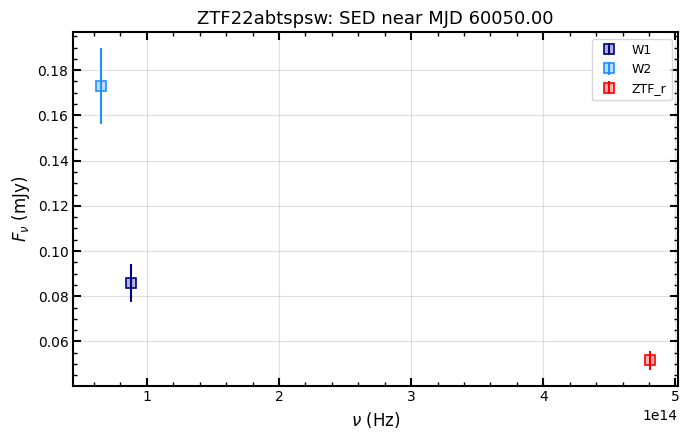

In [136]:
mjd_target = 60050.0   # <-- your chosen epoch
sed_tail = build_sed(mjd_target, ztf_resdict, wise_resdict, max_dt_ztf=3.0, max_dt_wise=3.0)
plot_sed(sed_tail, logy=False)

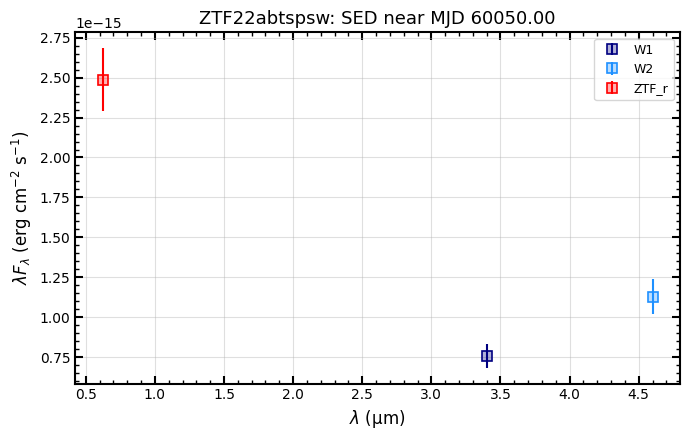

In [137]:
plot_sed(sed_tail, y_mode="Flam", logy=False)